In [1]:
import json
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Constants

figsize = (10,6)
pktPayloadSize = 1460 # Bytes
hdrSize = 40 #Bytes
torBw = 10e9 # bps
coreBw = 40e9 # bps

oneWayDel = 1.0e-6 \
         + (pktPayloadSize+hdrSize)*8*(2/torBw + 2/coreBw)
baseRtt = oneWayDel \
         + 1.0e-6 + 64*8*(2/torBw + 2/coreBw)

bdpPkts = 7

saturationTime = 3.1

In [3]:
# Helpers

def removeKey(d, key):
    r = dict(d)
    del r[key]
    return r

def getPctl(a, p):
    i = int(len(a) * p)
    return a[i]

In [4]:
filenames = ["trace/MsgTraces_different_1.tr", "trace/MsgTraces_same_1.tr"] 
# filenames = ["trace/different-MsgTraces_W5_load-50p_0.tr"]
# filenames = ["trace/MsgTraces_W5_load-80p_0_dynamic.tr"]

# filenames = ["trace/different-MsgTraces_W5_load-50p_0.tr", "trace/MsgTraces_W5_load-80p_0_dynamic.tr"]
# filenames = ["trace/MsgTraces_W5_load-80p_7_144.tr", "trace/different-MsgTraces_W5_load-50p_0.tr", "trace/MsgTraces_W5_load-80p_0_dynamic.tr"]

# filenames = ['trace/MsgTraces_W5_load-80p_7_8.tr']

In [5]:
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"]

In [6]:

# Verify filename matches format: trace/MsgTraces_W5_load-80p_7_8.tr
def verifyFilename(filename):
    if filename[:18] != "trace/MsgTraces_W5":
        print("Filename does not match format: MsgTraces_W5")
        return False
    if filename[-3:] != ".tr":
        print("Filename does not match format: .tr")
        return False
    return True

def getLoad(filename):
    return filename.split("_")[2].split("-")[1][:-1]

def getBDP(filename):
    return filename.split("_")[3]

def getNumNodes(filename):
    return filename.split("_")[4][:-3]


In [7]:
file_num_nodes = []
file_network_load = []
file_bdp = []

for i, filename in enumerate(filenames):
    num_nodes = 0
    networkLoad = 0
    bdp = "0"
    
    if verifyFilename(filename):
        try:
            num_nodes = int(getNumNodes(filename))
            networkLoad = float(getLoad(filename))/100
            bdp = getBDP(filename)
        except:
            print("Error parsing filename: " + filename)
    
    file_num_nodes.append(num_nodes)
    file_network_load.append(networkLoad)
    file_bdp.append(bdp)

Filename does not match format: MsgTraces_W5
Filename does not match format: MsgTraces_W5


In [8]:
fileMsgStartEntryDict = []
fileMsgCompletionTimesDict = []
fileAllMsgSizes = []
fileMsgSizePercentiles = []

In [9]:
for i, filename in enumerate(filenames):
    print(i, filename)

    # Dict of start time
    msgStartEntryDict = {}
    # Dict of completion time
    msgCompletionTimesDict = {}
    # List of all message sizes
    allMsgSizes = []

    with open(filename,'r') as f:
        for line in f:
            msgLog = line.split()

            time = float(msgLog[1])*1e-9        # in seconds
            msgSize = int(msgLog[2])            # in bytes
            sender = msgLog[3]                  # ip:port
            receiver = msgLog[4]                # ip:port
            txMsgId = int(msgLog[5])

            key = (sender, receiver, txMsgId, i)

            # Sender
            if (msgLog[0]=='+'):
                if (key in msgStartEntryDict):
                    msgStartEntryDict[key].append(time)
                else:
                    # Create new entry if not in dict
                    msgStartEntryDict[key] = [time]
            # Receiver
            elif (msgLog[0] =='-'):
                if (key in msgStartEntryDict):
                    # Find matching start entry
                    startTime = msgStartEntryDict[key].pop()

                    # Remove from startEntryDict (message completed)
                    if (len(msgStartEntryDict[key]) <= 0):
                        msgStartEntryDict = removeKey(msgStartEntryDict, key)

                    # Invalid
                    if(startTime < saturationTime):
                        continue
                    
                    # Valid
                    if (msgSize in msgCompletionTimesDict):
                        msgCompletionTimesDict[msgSize].append(time-startTime)
                    else:
                        # Create entry if not in dict
                        msgCompletionTimesDict[msgSize] = [time-startTime]

                    # Add to list of all message sizes
                    allMsgSizes.append(msgSize)
                else:
                    print('ERROR: Start entry of message (' \
                        + sender + ' > ' + receiver + ', ' + str(txMsgId) \
                        + ') not found!')
                    
    allMsgSizes = np.array(allMsgSizes)
    msgSizePercentiles = stats.rankdata(allMsgSizes, 'max')/len(allMsgSizes)*100

    fileMsgStartEntryDict.append(msgStartEntryDict)
    fileMsgCompletionTimesDict.append(msgCompletionTimesDict)
    fileAllMsgSizes.append(allMsgSizes)
    fileMsgSizePercentiles.append(msgSizePercentiles)

0 trace/MsgTraces_different_1.tr
1 trace/MsgTraces_same_1.tr


In [10]:
# Basic stats

for i, filename in enumerate(filenames):
    print("\n", i, filename)

    # Items remaining in startEntryDict were uncompleted
    numUncompleted = 0
    for msgKey, msgStartTimes in fileMsgStartEntryDict[i].items():
        numUncompleted += len(msgStartTimes)

    print('Number of uncompleted messages: ' + str(numUncompleted))
    print('Number of distinct message sizes: ' + str(len(fileMsgCompletionTimesDict[i])))

    cntMultMeasures = 0
    numMsgs = 0
    nonFullPacketMsgSizes = []
    for msgSize, msgCompletionTimes in fileMsgCompletionTimesDict[i].items():
        # Count number of distinct message sizes that have multiple measurements
        if (len(msgCompletionTimes)>1):
            cntMultMeasures += 1

        # Count number of distinct messages
        numMsgs += len(msgCompletionTimes)
        
        # Count number of non-full packet messages
        if (msgSize%pktPayloadSize != 0):
            nonFullPacketMsgSizes.append((msgSize,msgSize%pktPayloadSize))
        
    print('Number of distinct message sizes that have multiple measurements: ' + str(cntMultMeasures))   
    print('Number of distinct messages: ' + str(numMsgs)) 

    if (nonFullPacketMsgSizes):
        print('Non-Full Packet Message Sizes: ', nonFullPacketMsgSizes)


 0 trace/MsgTraces_different_1.tr
Number of uncompleted messages: 47
Number of distinct message sizes: 82
Number of distinct message sizes that have multiple measurements: 29
Number of distinct messages: 124

 1 trace/MsgTraces_same_1.tr
Number of uncompleted messages: 47
Number of distinct message sizes: 82
Number of distinct message sizes that have multiple measurements: 28
Number of distinct messages: 123


In [11]:
FileSimMsgSizes = []
FileSimP50CompletionTimes = []
FileSimP99CompletionTimes = []
FileSimBaseCompletionTimes = []
FileSimP50SlowDowns = []
FileSimP99SlowDowns = []

In [12]:
# Get slowdowns

for i, filename in enumerate(filenames):
    print("\n", i, filename)

    SimMsgSizes = []
    SimP50CompletionTimes = []
    SimP99CompletionTimes = []
    SimBaseCompletionTimes = []
    SimP50SlowDowns = []
    SimP99SlowDowns = []

    for msgSize, msgCompletionTimes in fileMsgCompletionTimesDict[i].items():
        
        SimMsgSizes.append(msgSize)
        
        times = np.array(msgCompletionTimes)
        p50CompletionTime = np.percentile(times,50)
        SimP50CompletionTimes.append(p50CompletionTime)
        p99CompletionTime = np.percentile(times,99)
        SimP99CompletionTimes.append(p99CompletionTime)
        
        totBytes = msgSize + math.ceil(msgSize / pktPayloadSize) * (hdrSize) 
        baseCompletionTime = totBytes * 8 / torBw;
        if (msgSize > bdpPkts * pktPayloadSize):
            baseCompletionTime += oneWayDel#baseRtt
        else:
            baseCompletionTime += oneWayDel
    #     baseCompletionTime = (msgSize+pktPayloadSize)*8.0/10e9 + 0.5e-6 \
    #                           + 2*pktPayloadSize*8.0/40e9 + 0.5e-6
        
        SimBaseCompletionTimes.append(baseCompletionTime)
        
        SimP50SlowDowns.append(p50CompletionTime / baseCompletionTime)
        SimP99SlowDowns.append(p99CompletionTime / baseCompletionTime)

    #     slowDowns = times / baseCompletionTime
    #     slowDowns = np.where(slowDowns < 1.0, 1.0, slowDowns)

    #     SimP50SlowDowns.append(np.percentile(slowDowns,50))
    #     SimP99SlowDowns.append(np.percentile(slowDowns,99))
        
    zipData = sorted(zip(SimMsgSizes,
                        SimP50CompletionTimes,
                        SimP99CompletionTimes,
                        SimBaseCompletionTimes,
                        SimP50SlowDowns,
                        SimP99SlowDowns))
        
    SimMsgSizes = np.array([x for x,_,_,_,_,_ in zipData])
    SimP50CompletionTimes = np.array([x for _,x,_,_,_,_ in zipData])
    SimP99CompletionTimes = np.array([x for _,_,x,_,_,_ in zipData])
    SimBaseCompletionTimes = np.array([x for _,_,_,x,_,_ in zipData])
    SimP50SlowDowns = np.array([x for _,_,_,_,x,_ in zipData])
    SimP99SlowDowns = np.array([x for _,_,_,_,_,x in zipData])

    FileSimMsgSizes.append(SimMsgSizes)
    FileSimP50CompletionTimes.append(SimP50CompletionTimes)
    FileSimP99CompletionTimes.append(SimP99CompletionTimes)
    FileSimBaseCompletionTimes.append(SimBaseCompletionTimes)
    FileSimP50SlowDowns.append(SimP50SlowDowns)
    FileSimP99SlowDowns.append(SimP99SlowDowns)


 0 trace/MsgTraces_different_1.tr

 1 trace/MsgTraces_same_1.tr


In [13]:
def moving_average(data, window_size):
    return pd.Series(data).rolling(window=window_size).mean()

In [14]:
def plot_file(i, window_size=5, plot_avg=False, only50=False, only99=False):
    x = [fileMsgSizePercentiles[i][np.where(fileAllMsgSizes[i] == msgsize)[0][0]] for msgsize in FileSimMsgSizes[i]]
    y50 = FileSimP50SlowDowns[i]
    y99 = FileSimP99SlowDowns[i]

    # Calculate moving averages
    moving_avg_50 = moving_average(y50, window_size=window_size)
    moving_avg_99 = moving_average(y99, window_size=window_size)

    label = f'{file_num_nodes[i]}nodes_{file_network_load[i]}load_{file_bdp[i]}pkts'

    plot_both = not only50 and not only99
    if not plot_avg:
        if only50 or plot_both: plt.step(x, y50, label=f'{label} 50%', color=colors[i], linestyle='--')
        if only99 or plot_both: plt.step(x, y99, label=f'{label} 99%', color=colors[i])

    # Plot moving averages
    if plot_avg:
        if only50 or plot_both: plt.plot(x, moving_avg_50, label=f'{label} 50%', color=colors[i])
        if only99 or plot_both: plt.plot(x, moving_avg_99, label=f'{label} 99%', color=colors[i])

    # Existing plotting code...
    plt.ylabel('Slow Down')
    plt.xlabel('Message Size (Bytes)')
    plt.title(f'Homa Message Completion Slowdown for {file_num_nodes[i]} Nodes with {file_network_load[i]*100}% Load')
    plt.legend(loc='upper left')
    # ----------------------------------------------

    xTickPercentiles = np.linspace(10, 100, 10)
    xticks = np.percentile(fileAllMsgSizes[i],xTickPercentiles).astype(int) 
    plt.xticks(xTickPercentiles, xticks, rotation=45)

    plt.yscale('log')
    plt.ylim([1,30])
    yticks = [1,2,3,4,5,10,20,30]
    plt.yticks(yticks, yticks)

    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.tight_layout()


 0 trace/MsgTraces_different_1.tr



 1 trace/MsgTraces_same_1.tr


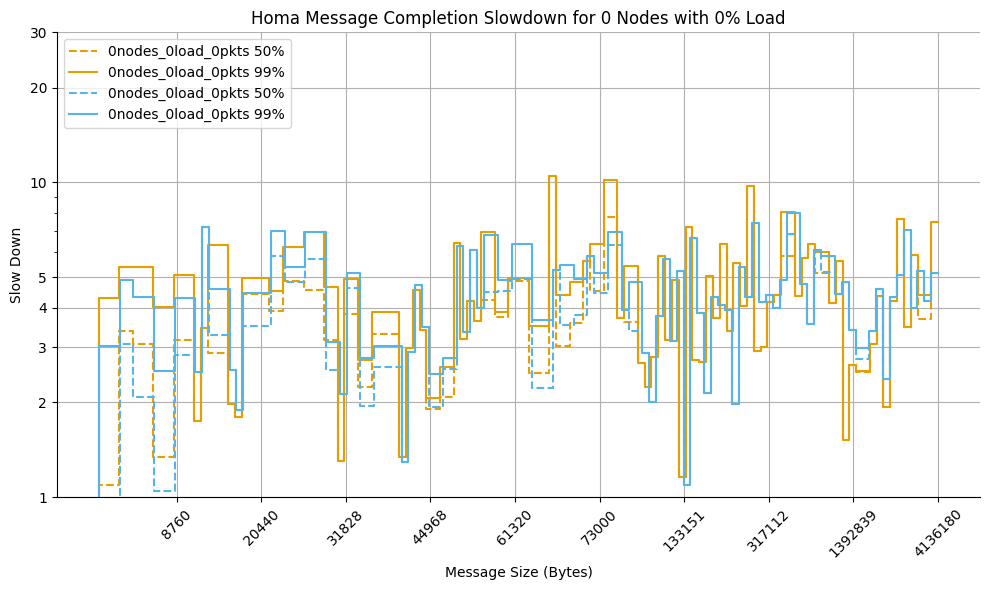


 0 trace/MsgTraces_different_1.tr

 1 trace/MsgTraces_same_1.tr


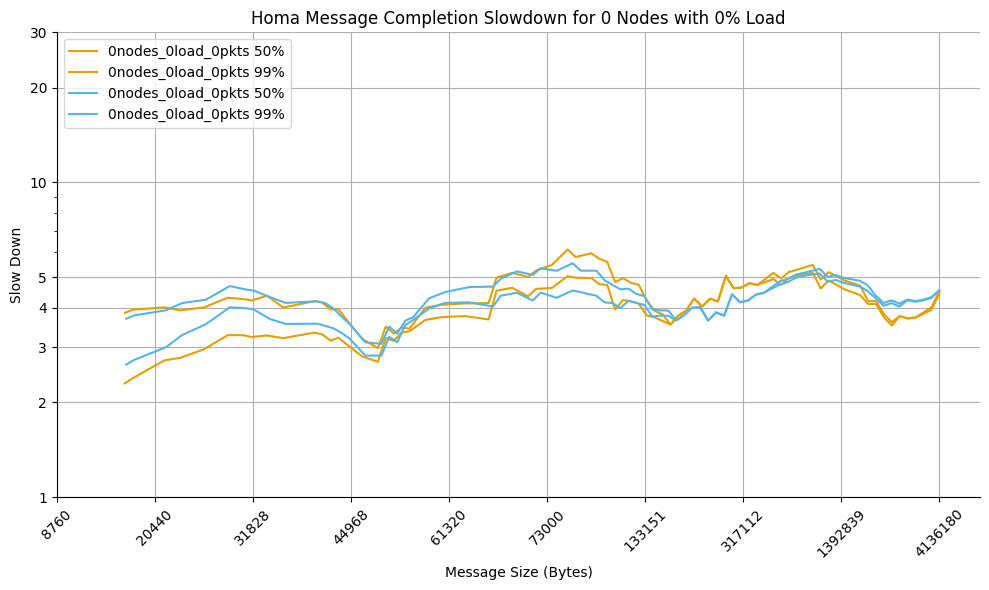

In [15]:
# Plotting

plt.figure(figsize=figsize)
plt.grid()
for i, filename in enumerate(filenames):
    print("\n", i, filename)
    plot_file(i)
plt.show()

# Smoothed
plt.figure(figsize=figsize)
plt.grid()
for i, filename in enumerate(filenames):
    print("\n", i, filename)
    plot_file(i, window_size=10, plot_avg=True)
plt.show()

In [16]:
# Separate plots


 0 trace/MsgTraces_different_1.tr

 1 trace/MsgTraces_same_1.tr


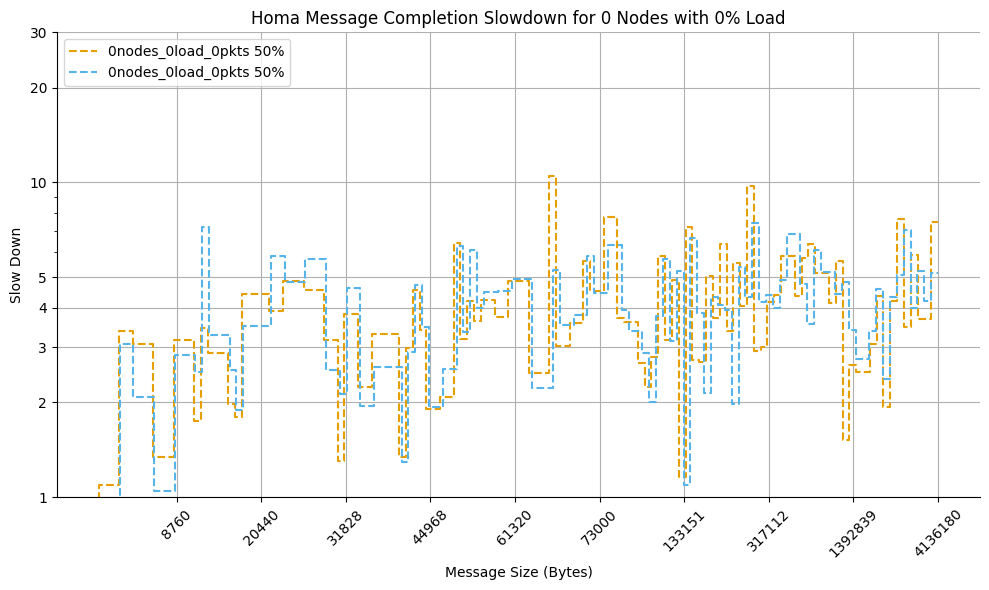


 0 trace/MsgTraces_different_1.tr

 1 trace/MsgTraces_same_1.tr


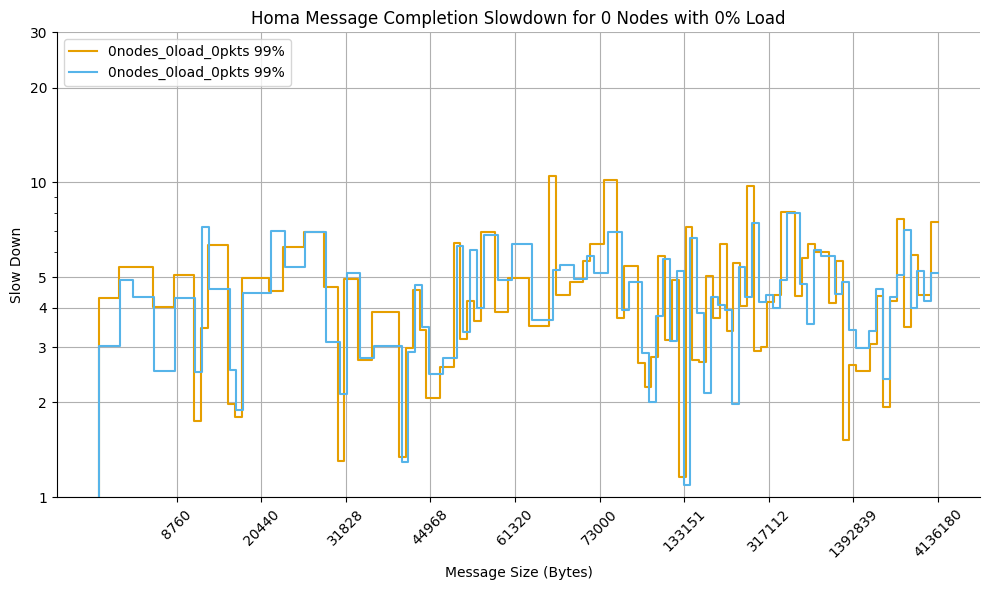

In [17]:
plt.figure(figsize=figsize)
plt.grid()
for i, filename in enumerate(filenames):
    print("\n", i, filename)
    plot_file(i, only50=True)
plt.show()

plt.figure(figsize=figsize)
plt.grid()
for i, filename in enumerate(filenames):
    print("\n", i, filename)
    plot_file(i, only99=True)
plt.show()